In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import hdbscan
import sys
import os
import json
import cudf
import cugraph
import cudf
import cugraph
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client



## The code should be run on DTU's HPC.
## Everyone should have access to the directory that is specified here.

json_file = open("FamilyTranslation.json")
translations = json.load(json_file)


sys.path.append("/dtu/blackhole/19/155129/")
os.chdir("/dtu/blackhole/19/155129/")
df = pd.read_csv("csv_without_duplicates_long_lat_family.csv")
X = df[['decimalLatitude', 'decimalLongitude']].values
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, )
cluster_labels = clusterer.fit_predict(X)
# Map translations
df['family_danish'] = df['family'].map(translations).fillna(df['family'])
df['cluster'] = cluster_labels


/tmp/ipykernel_4189516/667257876.py:10: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("csv_without_duplicates_long_lat_family.csv")


In [ ]:

df['cluster'] = cluster_labels

plt.scatter(df['decimalLongitude'], df['decimalLatitude'], c=df['cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('HDBSCAN Clustering')
plt.show()


In [ ]:
cluster = LocalCUDACluster()
client = Client(cluster)
gdf = cudf.read_csv("Edge_list.csv", names=["src", "dst"], dtype=["uint32", "uint32"])
G = cugraph.Graph(directed=False)
G.from_cudf_edgelist(gdf, source='src', destination='dst')
partitions = cugraph.louvain(G)
print(partitions)


(        partition      vertex
0             257  3336952372
1            1549  2351007384
2             257   552385075
3             257  3752867350
4             257  3324321304
...           ...         ...
884502       4875  2351006889
884503      48015  2238487327
884504      16384  2238481624
884505      46807  2237952300
884506      35426  4100098871

[884507 rows x 2 columns], 0.9936927556991577)


In [ ]:
louvain_mapping = partitions[0].to_pandas()  
louvain_mapping.columns = [ 'louvain_cluster','node_id']
df_new = df.merge(louvain_mapping, left_on='gbifID', right_on='node_id', how='left').copy().dropna(subset= ["node_id"])

df_no_noise = df_new[df_new['cluster'] != -1]
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari_no_noise = adjusted_rand_score(df_no_noise['cluster'], df_no_noise['louvain_cluster'])
nmi_no_noise = normalized_mutual_info_score(df_no_noise['cluster'], df_no_noise['louvain_cluster'])
print("Adjusted Rand Index (No Noise):", ari_no_noise)
print("NMI (No Noise):", nmi_no_noise)
print("Number of clusters, Louvain:",len(df_no_noise["louvain_cluster"].unique()))
print("Number of clusters, HDBSCAN:",len(df_no_noise["cluster"].unique()))


avg_hdbscan_size = df_no_noise['cluster'].value_counts().mean()
avg_louvain_size = df_no_noise['louvain_cluster'].value_counts().mean()
print("Average HDBSCAN Cluster Size:", avg_hdbscan_size)
print("Average Louvain Cluster Size:", avg_louvain_size)


Adjusted Rand Index (No Noise): 0.0780722146794752
NMI (No Noise): 0.887233177316378
Number of clusters, Louvain: 37781
Number of clusters, HDBSCAN: 73189
Average HDBSCAN Cluster Size: 9.395387284974518
Average Louvain Cluster Size: 18.20065641459993


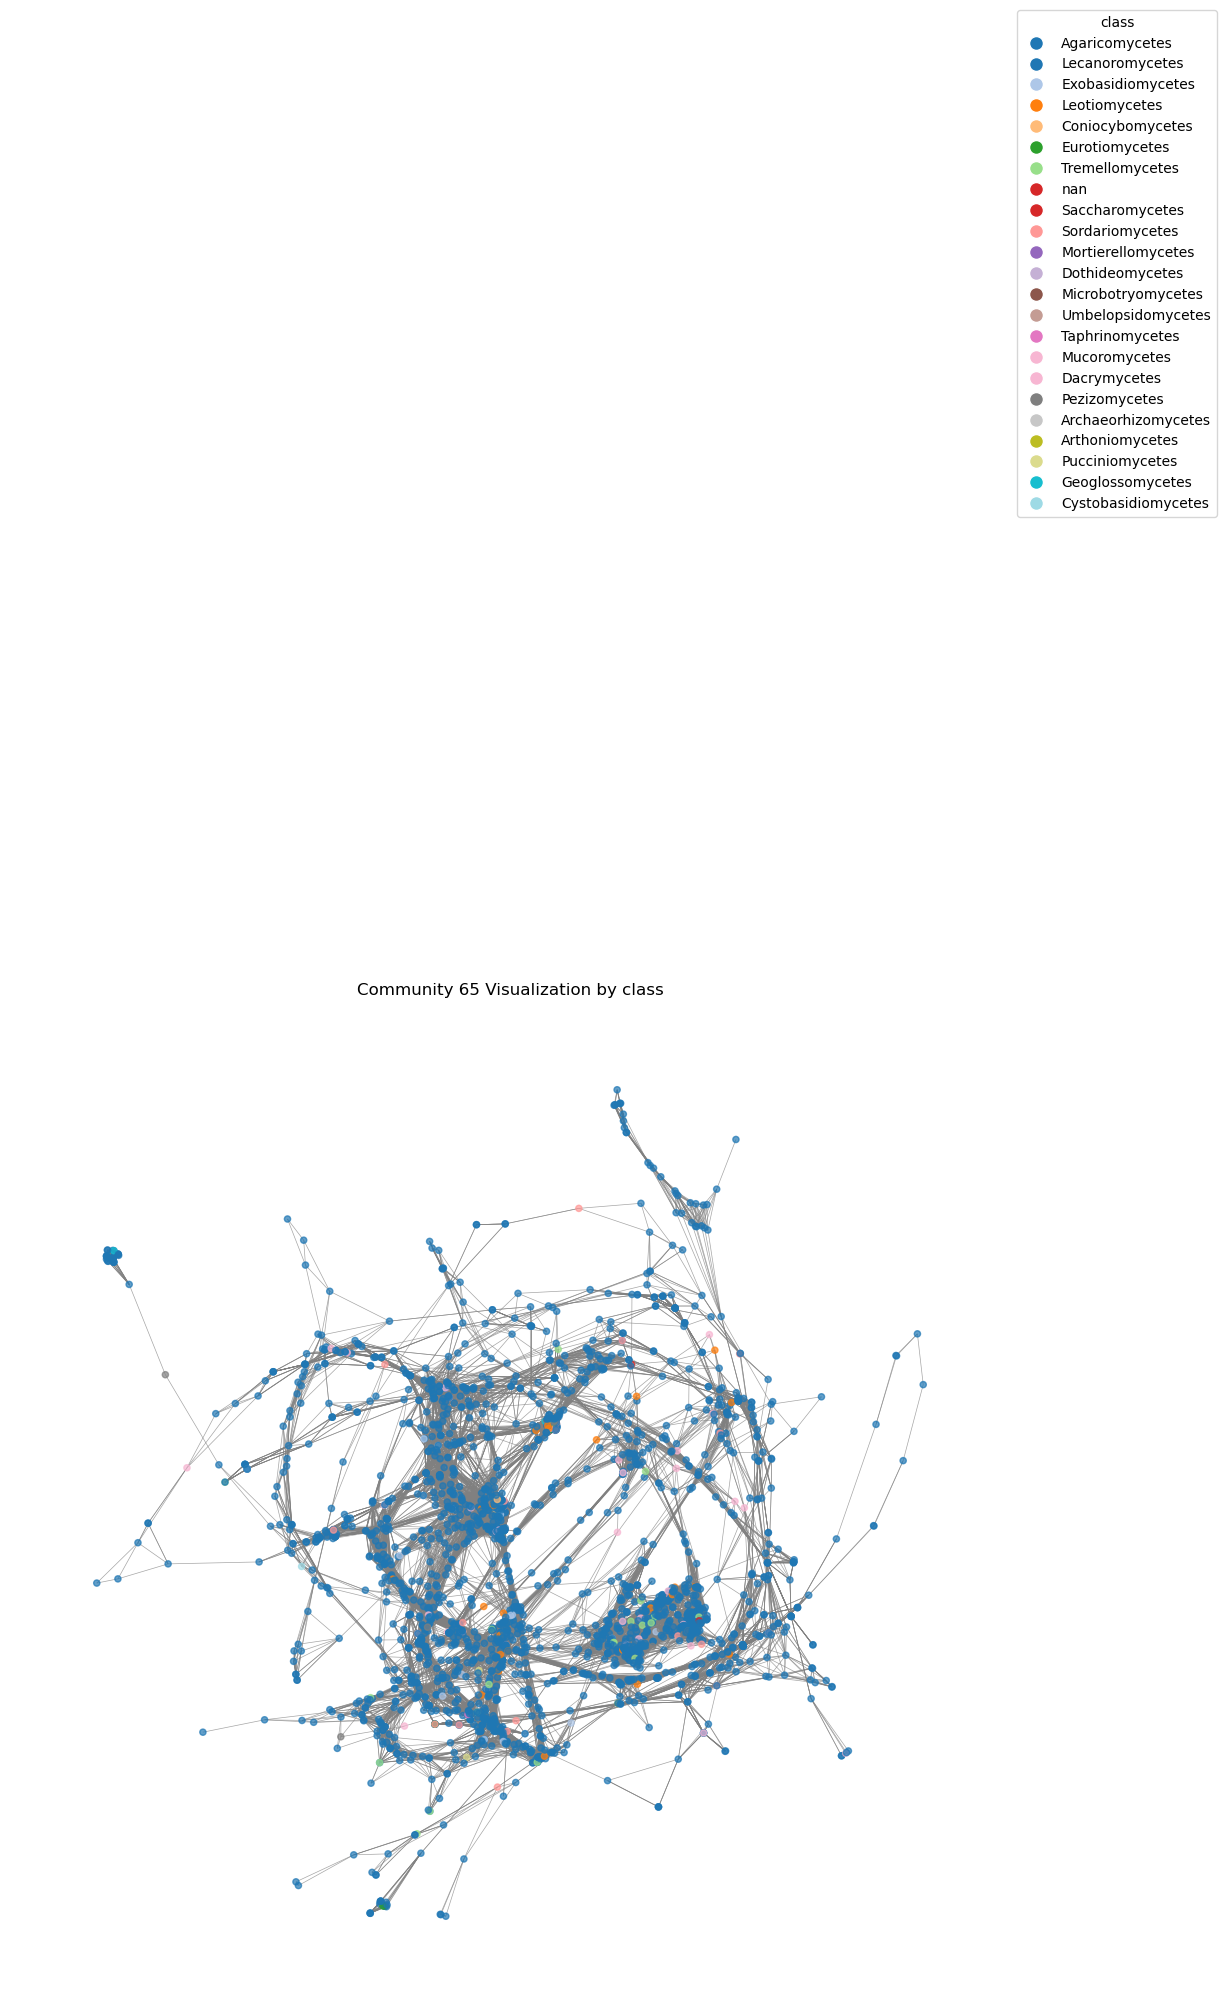

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import cudf
import pandas as pd

# Assuming `metadata_df` contains 'vertex' and 'family' columns with node and family information

# Transfer data to CPU if necessary
edges_df = gdf.to_pandas()
partitions_df = partitions[0].to_pandas()

# Merge partitions and metadata based on vertex IDs
nodes_with_metadata = partitions_df.merge(df, left_on='vertex', right_on='gbifID')

# Filter nodes and edges to focus on a specific community (e.g., community ID 65)
community_id = 65
community_nodes = nodes_with_metadata[nodes_with_metadata['partition'] == community_id]
community_node_ids = community_nodes['vertex'].tolist()
community_edges = edges_df[edges_df['src'].isin(community_node_ids) & edges_df['dst'].isin(community_node_ids)]

# Create NetworkX graph
G_community = nx.from_pandas_edgelist(community_edges, 'src', 'dst')

# Map each family to a unique color
families = community_nodes['class'].unique()
color_map = {family: plt.cm.tab20(i / len(families)) for i, family in enumerate(families)}

# Get node colors based on family
node_colors = [color_map[community_nodes.loc[community_nodes['vertex'] == node, 'class'].values[0]] 
               for node in G_community.nodes()]

# Plot the graph with family colors
plt.figure(figsize=(10, 10))
nx.draw(G_community, node_color=node_colors, with_labels=False, node_size=20, edge_color='gray', alpha=0.7, width = 0.5)

# Add a legend with family names
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[family], markersize=10)
                  for family in families]
plt.legend(legend_handles, families, title="class", loc="upper left", bbox_to_anchor=(1, 2))

plt.title(f"Community {community_id} Visualization by class")
plt.show()


50715
795762


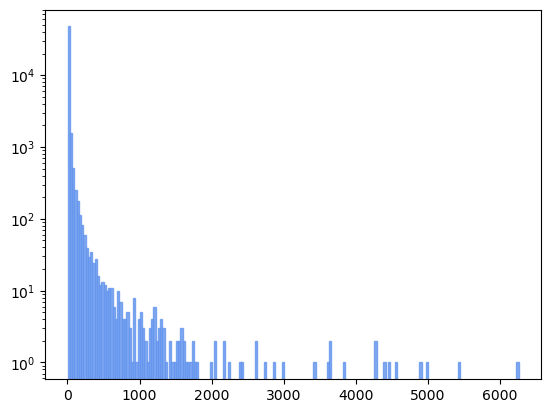

In [ ]:


edge_list = G.view_edge_list()

G_nx = nx.from_pandas_edgelist(edge_list.to_pandas(), source='src', target='dst')
cc = nx.connected_components(G_nx)
gcc = max(cc,key= len)

all_cc_length = [len(c) for c in sorted(nx.connected_components(G_nx), key=len, reverse=True)]
all_cc_length = np.array(all_cc_length)
filter_two = all_cc_length[(all_cc_length > 1) &(all_cc_length <8000) ] 
print(len(filter_two))
print(sum(filter_two))
plt.hist(filter_two, bins=200, edgecolor='cornflowerblue', color='cornflowerblue', alpha=0.8, log=True)
plt.show()

In [ ]:

df_gcc = df[df["gbifID"].isin(gcc)]
max_long = max(df_gcc["decimalLongitude"])
max_lat = max(df_gcc["decimalLatitude"])
min_lat = min(df_gcc["decimalLatitude"])
min_long = min(df_gcc["decimalLongitude"])
gcc_graph = G_nx.subgraph(gcc)
df_gcc["coordinates"] = df_gcc.apply(lambda x: (x["decimalLongitude"], x["decimalLatitude"]), axis = 1)
gcc_node_attributes = {row["gbifID"]: {"coordinate": row["coordinates"]} for _, row in df_gcc.iterrows()}

nx.set_node_attributes(gcc_graph, gcc_node_attributes)


nodes_to_remove = []
for i,node in enumerate(gcc_graph.nodes):
    if len(gcc_graph.nodes[node])< 1:
        nodes_to_remove.append(node)
        
gcc_graph = nx.Graph(gcc_graph)

for node in nodes_to_remove:
    gcc_graph.remove_node(node)

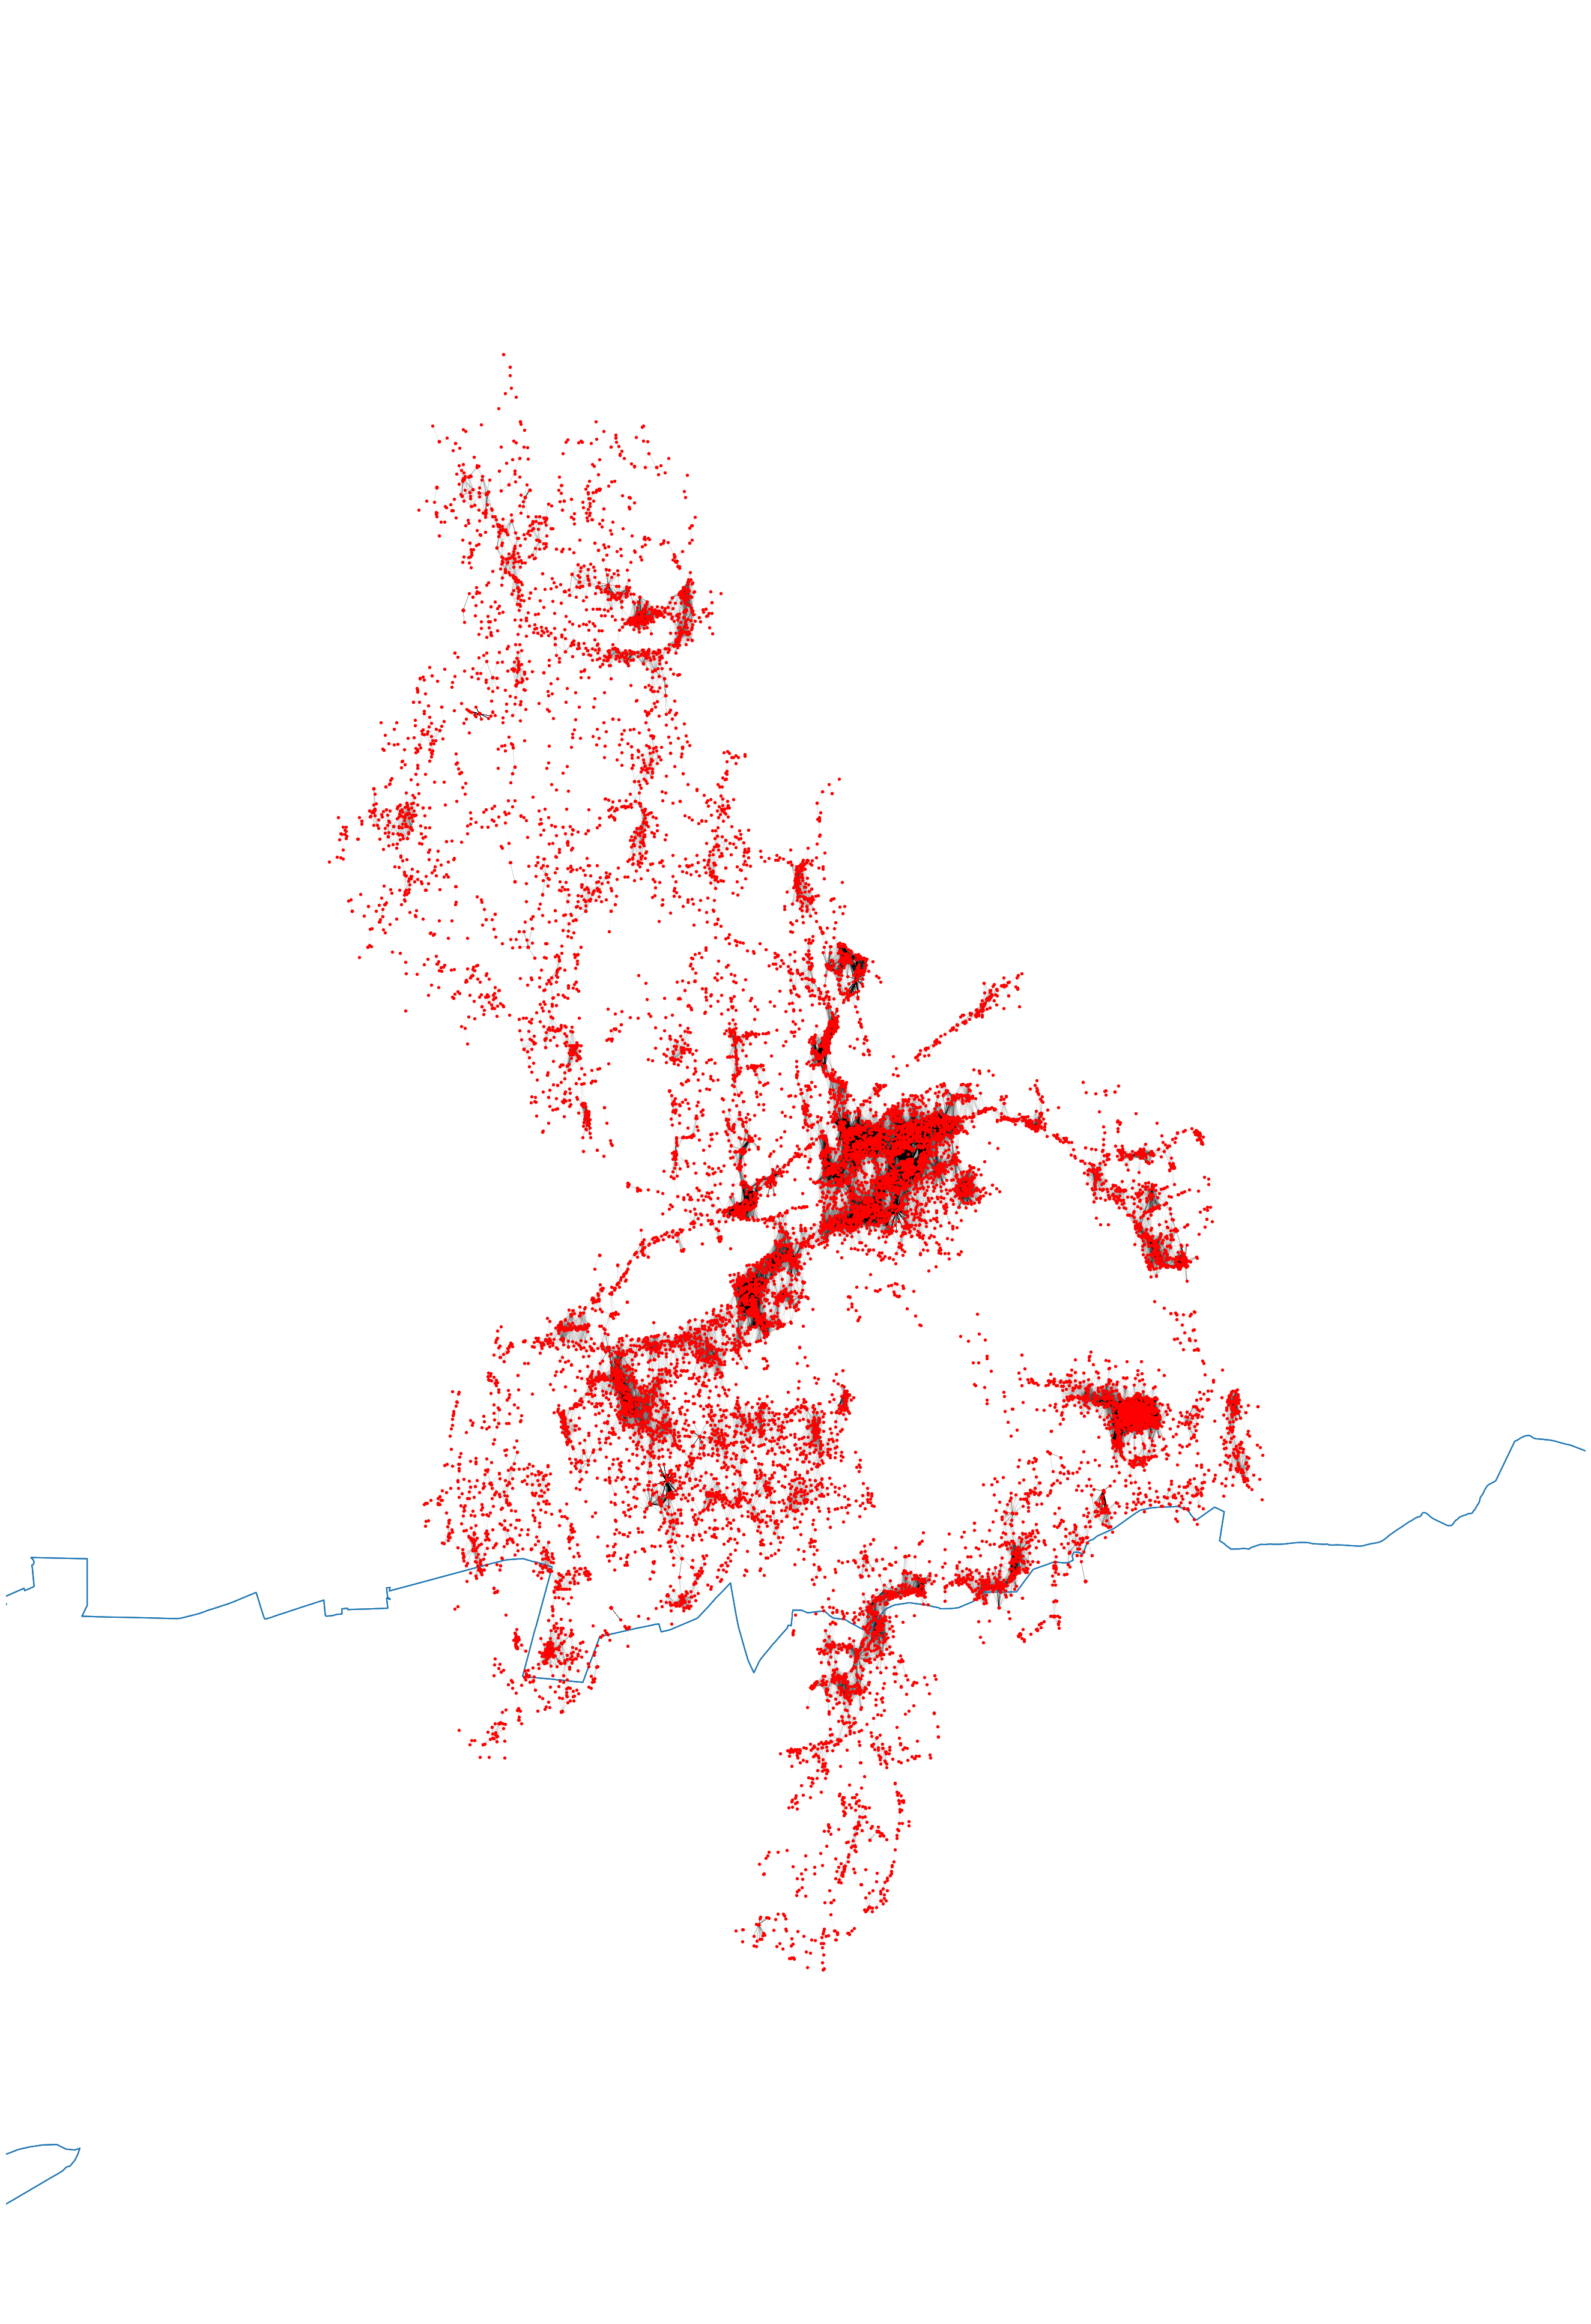

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from osmnx import settings as sets
## The plot in the report was generated using this code together with some more code, but the packages suddenly stopped working so they were excluded from the script

denmark = gpd.read_file("Denmark_top.geojson")

positions = nx.get_node_attributes(gcc_graph, 'coordinate')

fig, ax = plt.subplots(figsize=(50, 50))
denmark.boundary.plot(ax=ax) 
bbox_coords = [min_long, min_lat, max_long, max_lat]  
sets.cache_folder = "~/cache/"

# Ensure the directory exists
os.makedirs(sets.cache_folder, exist_ok=True)

nx.draw(
    gcc_graph,
    pos=positions,  # Use positions from the DataFrame
    ax=ax,
    with_labels=False,
    node_size=8,
    node_color='red',
    edge_color='black',
    width = 0.01
)

ax.set_xlim(bbox_coords[0] - 0.025, bbox_coords[2] + 0.025) 
ax.set_ylim(bbox_coords[1] - 0.015, bbox_coords[3] + 0.015)  
plt.show()

In [ ]:
all_cc = [c for c in sorted(nx.connected_components(G_nx), key=len, reverse=True)]
intra_community_density = {}
for community_id in partitions[0]['partition'].unique().to_pandas():
    community_nodes = partitions[0][partitions[0]['partition'] == community_id]['vertex']
    subgraph = G_nx.subgraph(community_nodes.values.tolist())
    intra_community_density[community_id] = nx.density(subgraph)

intra_community_density_df = pd.DataFrame(list(intra_community_density.items()), columns=['Community', 'Density'])
print("Intra-community Density:\n", intra_community_density_df)

Intra-community Density:
        Community   Density
0             63  0.150821
1             35  0.093403
2             51  0.216042
3            261  0.228437
4            541  0.074413
...          ...       ...
50939      50910  1.000000
50940      49007  1.000000
50941      49249  1.000000
50942      48006  1.000000
50943      50493  1.000000

[50944 rows x 2 columns]


In [ ]:
subgraph = G_nx.subgraph(gcc)
nx.density(subgraph)
community_list_family = []
node_set = set(G_nx.nodes)
df_extra = df[df["gbifID"].isin(node_set)]
for community_id in df_extra["family_danish"].unique():
    nodes =df_extra["gbifID"][(df_extra["family_danish"] == community_id)]
    community_list_family.append(set(nodes.values.tolist()))
degrees = dict(G_nx.degree())
df['occurrences'] = df.groupby('family_danish')['family_danish'].transform('count')

In [ ]:
df.groupby('family_danish')['family_danish'].count().mean()  

1436.308777429467

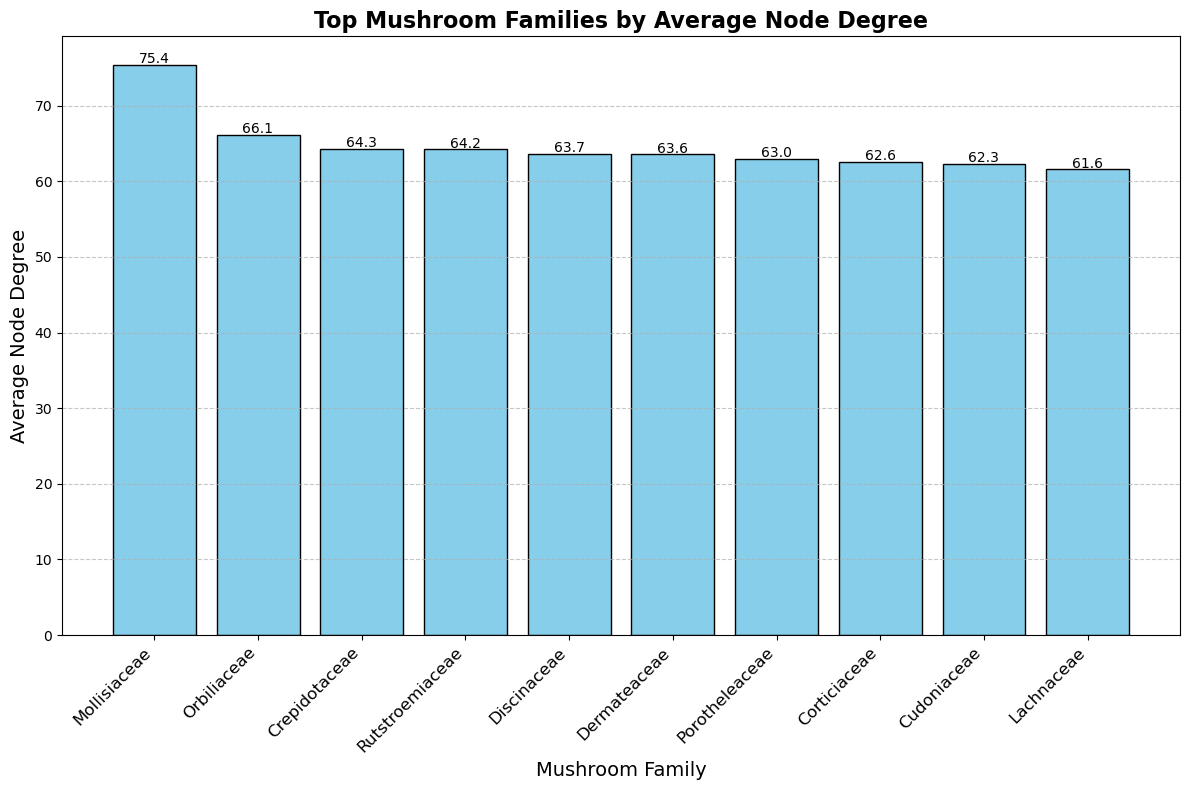

In [116]:
df['degree'] = df['gbifID'].map(degrees)

global_mean = df['degree'].mean()
alpha = df.groupby('family_danish')['family_danish'].count().mean()  
df['regularized_degree'] = (
    (df['degree'] * df['occurrences'] + global_mean * alpha) /
    (df['occurrences'] + alpha      )
)


family_regularized_mean = df.groupby('family_danish')['regularized_degree'].mean()
family_regularized_mean = family_regularized_mean.sort_values(ascending= False)

top_families = family_regularized_mean.head(10)  

families = list(top_families.keys())
degrees = list(top_families)
plt.figure(figsize=(12, 8))
bars = plt.bar(families, degrees, color='skyblue', edgecolor='black')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2 - 0.15,
             bar.get_height() + 0.2,
             f'{bar.get_height():.1f}',
             fontsize=10,
             color='black')

plt.title('Top Mushroom Families by Average Node Degree', fontsize=16, fontweight='bold')
plt.xlabel('Mushroom Family', fontsize=14)
plt.ylabel('Average Node Degree', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

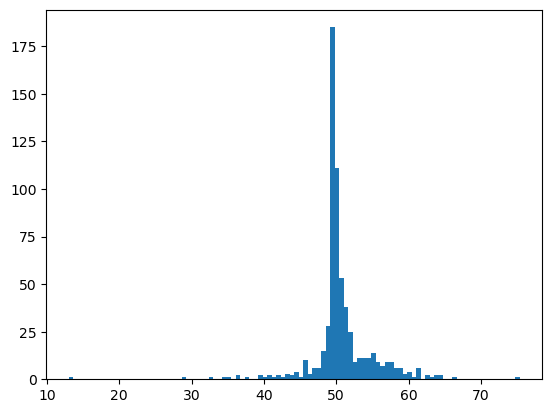

In [98]:
plt.hist(family_regularized_mean.values[family_regularized_mean.values > 1], bins = 100)
plt.show()

In [99]:
top_families

family_danish
Mollisiaceae       75.386329
Orbiliaceae        66.143933
Crepidotaceae      64.272074
Rutstroemiaceae    64.243324
Discinaceae        63.655377
Dermateaceae       63.583523
Porotheleaceae     62.989256
Corticiaceae       62.582361
Cudoniaceae        62.296518
Lachnaceae         61.606840
Name: regularized_degree, dtype: float64

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = num_edges / num_nodes
density = nx.density(G)

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Average Degree: {avg_degree}")
print(f"Density: {density}")


Number of Nodes: 884507
Number of Edges: 21797762
Average Degree: 24.643967769616296
Density: 5.5723687051566174e-05


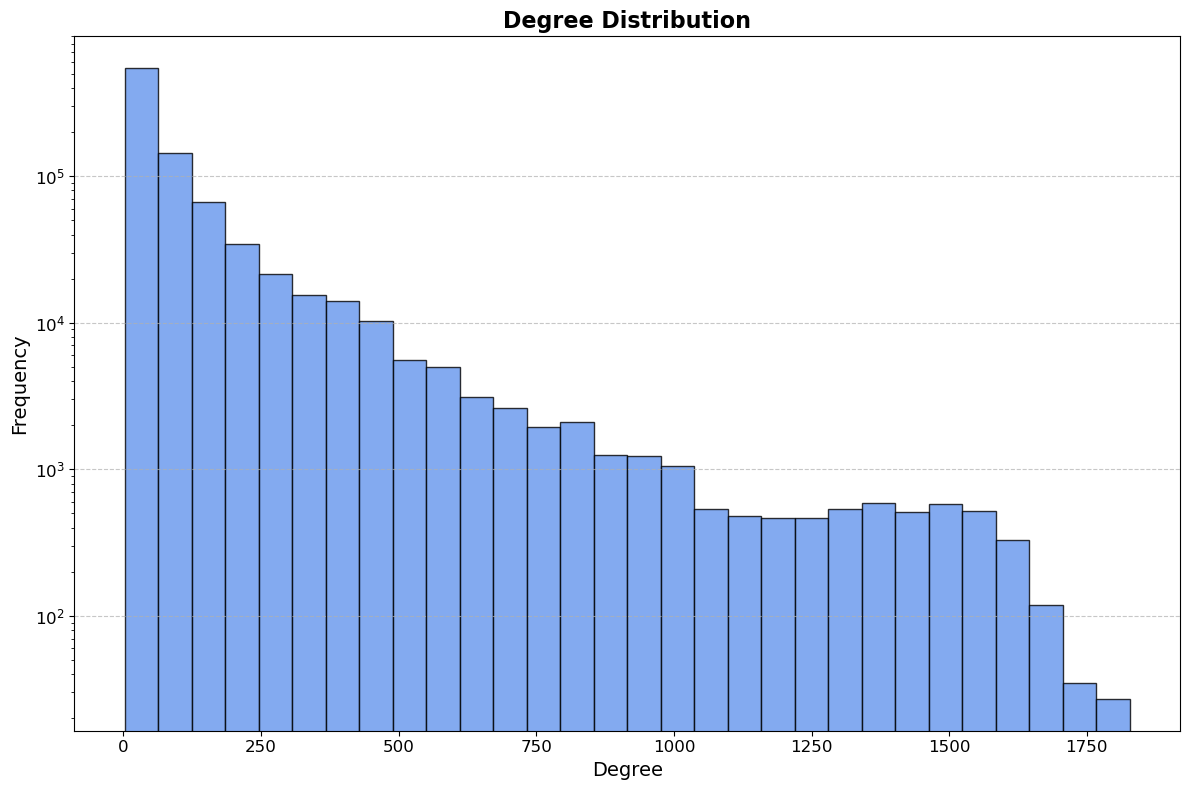

/dtu/blackhole/0e/154958/miniconda/envs/gpu_graph/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [302]:
import matplotlib.pyplot as plt

degree_df = G.degree()

plt.figure(figsize=(12, 8))
plt.hist(degree_df["degree"], bins=30, edgecolor='black', color='cornflowerblue', alpha=0.8, log=True)

# Enhancements
plt.title("Degree Distribution", fontsize=16, fontweight='bold')

plt.xlabel("Degree", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


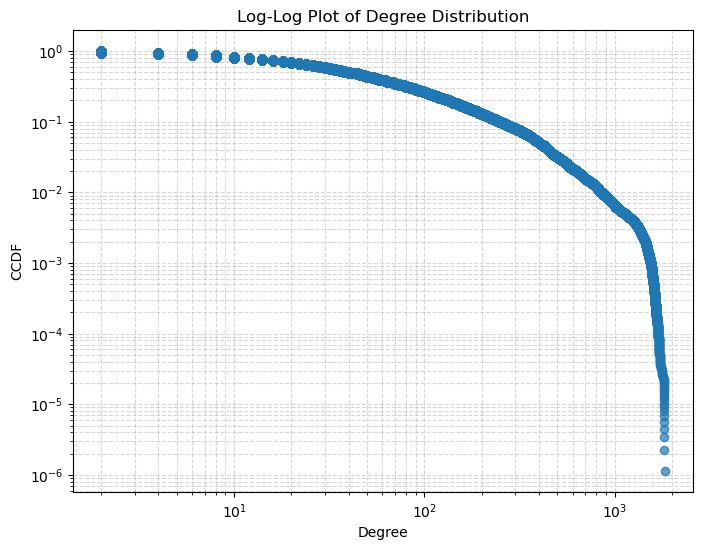

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Validate where the log-log plot begins to look linear, ~100.
#Xmin should be 100
data = degree_df["degree"].to_numpy()
sorted_data = np.sort(data)
ccdf = 1. - np.arange(1, len(data)+1) / len(data)

plt.figure(figsize=(8, 6))
plt.loglog(sorted_data, ccdf, marker="o", linestyle="none", alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("CCDF")
plt.title("Log-Log Plot of Degree Distribution")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()


In [317]:
import powerlaw as pwl
fit_function = pwl.Fit(degree_df["degree"].to_numpy(), xmin = 100)
print(fit_function.power_law.alpha)
print(fit_function.power_law.sigma)


2.2261658897974232
0.0025373952316942168
